## Load libraries and functions

In [65]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
# import the KMeans clustering model from scikit-learn
import matplotlib.pyplot as plt

from myVAR import myVAR,adfuller_test,plot_vars,plot_comparison

import warnings
warnings.filterwarnings('ignore')

## Instantiate a VAR with parameters

In [66]:
country='China' #parameter
nobs=1 #parameter
forecast_steps=9 #parameter

# load the data
ts=pd.read_csv('data/var_data_COMPLETE.csv',index_col='Year')
# ts.drop(columns=['Temperature (annual mean)','Population density (people per sq. km of land area)'],inplace=True)
ts=ts.loc[ts['Country'] == country]
ts.drop(columns=['Country'],inplace=True)
ts.interpolate(method='linear', axis=0,inplace=True)
v1=myVAR(ts)

### Plot the time series:

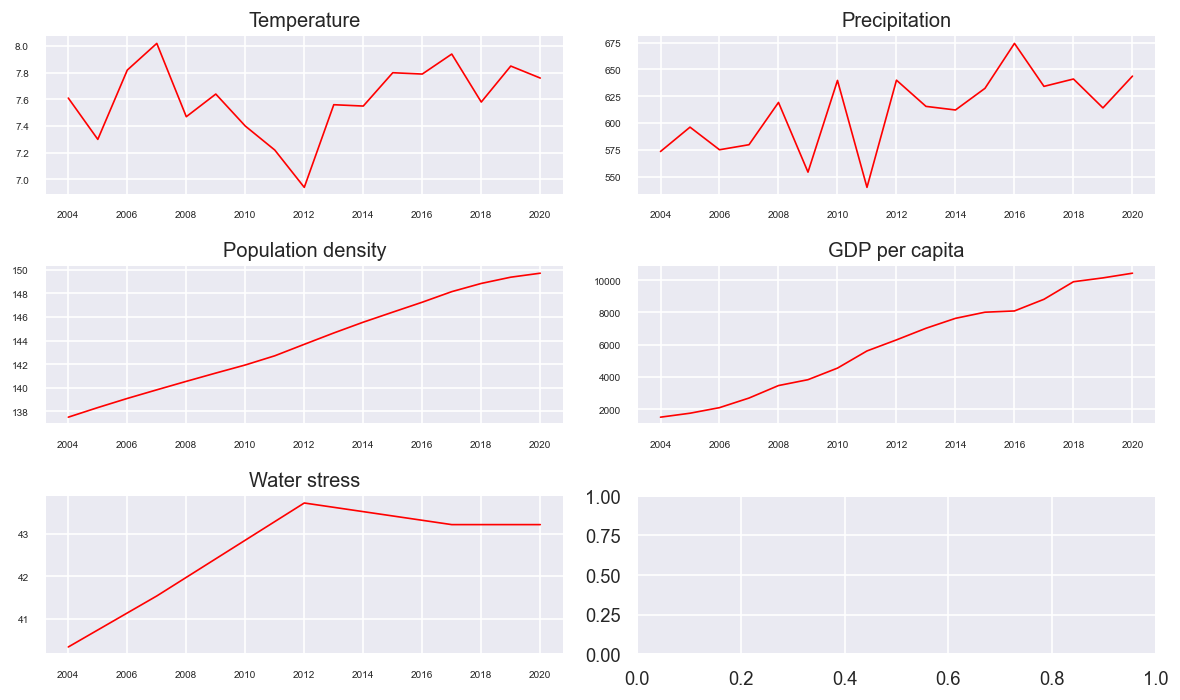

In [67]:
plot_vars(ts)

## Train/Validation split

In [68]:
v1.ts_split(nobs)

## Stationarity check

In [69]:
diff_order=2 #parameter
v1.ts_train_diff=v1.get_diff(v1.ts_train,diff_order,verbose=True)

['Temperature', 'Precipitation', 'Population density', 'GDP per capita', 'Water stress']
['Water stress']


## Granger causality 

<AxesSubplot:>

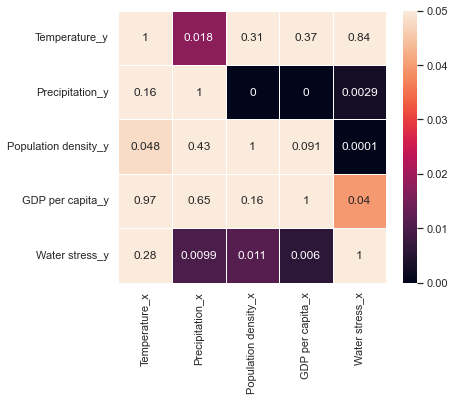

In [70]:
granger_result=v1.granger_matrix()
plt.figure(figsize=(6,5))
sns.heatmap(granger_result,annot=True, linewidths=.5, vmax=.05)

## Cointegration test


In [71]:
v1.cointegration_test()

Name::Test Stat > C(95%)=>Signif  
 ----------------------------------------
Temperature ::  155.19 > 60.0627  =>   Sig.
Precipitation ::  64.48 > 40.1749  =>   Sig.
Population density ::  26.1 > 24.2761  =>   Sig.
GDP per capita ::  4.09 > 12.3212  =>   Not sig.
Water stress ::  0.89 > 4.1296  =>   Not sig.


## Fit the model

select best lag value

In [72]:
v1.inspect_lag(5)

1 7.587184317764241
ERROR
3 -278.7431725204021
4 -291.0576242596741
5 -297.78777289480274


In [73]:
p=1 #parameter
v1.fit = v1.get_fit(p)
v1.fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Jun, 2022
Time:                     03:14:13
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    8.89091
Nobs:                     13.0000    HQIC:                   7.31921
Log likelihood:          -111.548    FPE:                    2876.83
AIC:                      7.58718    Det(Omega_mle):         431.383
--------------------------------------------------------------------
Results for equation Temperature
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.021471         0.133374            0.161           0.872
L1.Temperature               -0.493990         0.348961           -1.416           0.157
L1.Precipitation      

### autocorrelation plots

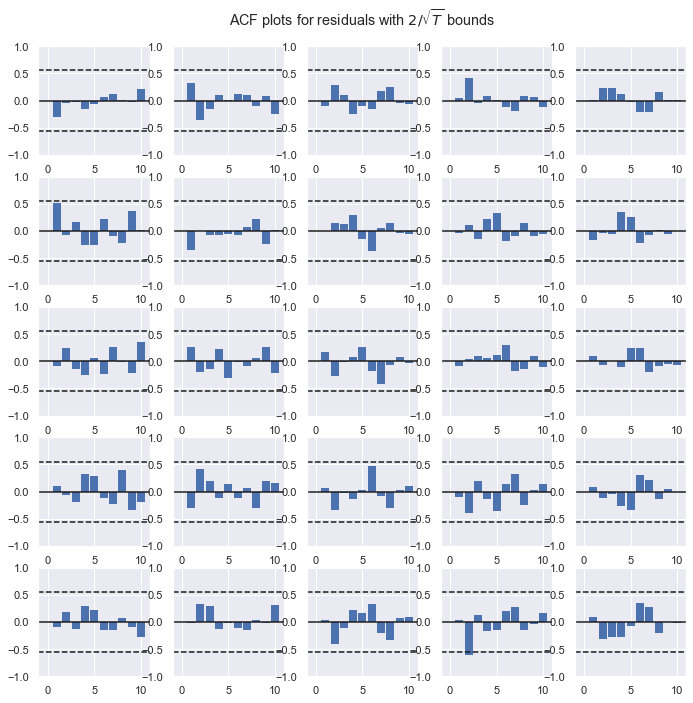

In [74]:
v1.fit.plot_acorr();

## serial correlation check

2.37 Temperature
2.63 Precipitation
1.63 Population density
2.04 GDP per capita
1.46 Water stress


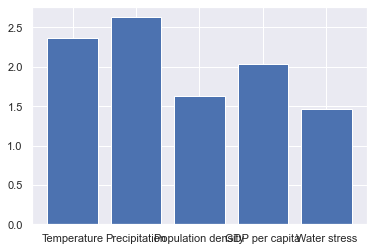

In [75]:
v1.check_serial_correlation(plot=True)

## Forecast

In [76]:
v1.ts_forecast_diff=v1.get_forecast_diff(forecast_steps,plot=False)
# v1.ts_forecast_diff

## Invert differencing

In [77]:
v1.ts_forecast = v1.get_inv_diff(v1.ts_forecast_diff,diff_order)
v1.ts_forecast.head()

,Temperature,Precipitation,Population density,GDP per capita,Water stress
2020,7.962271,674.590551,149.856923,10390.626955,43.230529
2021,8.244528,656.855044,150.301636,10627.461997,43.160175
2022,8.311910,706.906365,150.730856,10786.149690,43.140846
2023,8.619493,711.568813,151.141993,10948.337912,43.030504
2024,8.730645,751.895069,151.534027,11115.555676,42.917661


## Evaluate the forecast

In [78]:
v1.ts_results=pd.concat([v1.ts_train,v1.ts_forecast])
# v1.ts_results.tail()

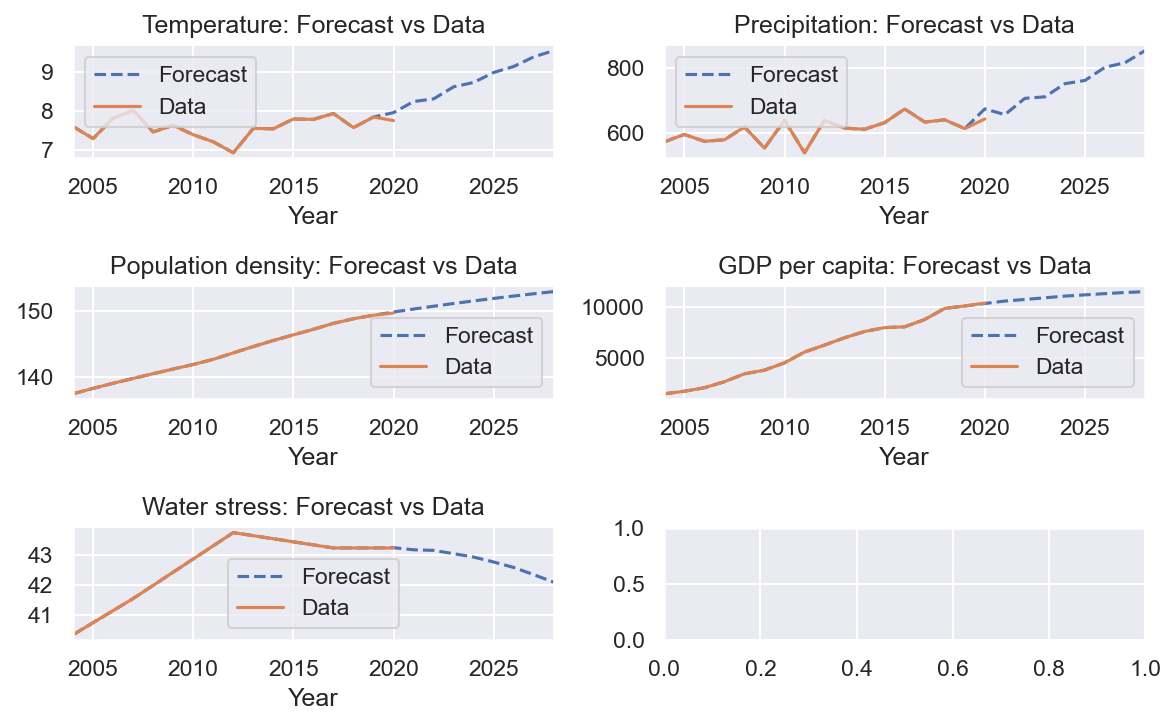

In [79]:
plot_comparison(v1.ts,v1.ts_results,steps=forecast_steps)

In [80]:
error=v1.get_forecast_error(v1.ts_forecast)
error
# error.loc[['RMSE'],['Water stress']]

,Temperature,Precipitation,Population density,GDP per capita,Water stress
ME,0.026066,0.047859,0.001012,0.004231,0.000205
MPE,0.202271,30.810551,0.151476,-44.148235,0.008842
MAE,0.202271,30.810551,0.151476,44.148235,0.008842
MAPE,0.026066,0.047859,0.001012,-0.004231,0.000205
RMSE,0.202271,30.810551,0.151476,44.148235,0.008842
Corr,NaN,NaN,NaN,NaN,NaN
Min/Max,0.025404,0.045673,0.001011,0.004231,0.000205
